# New Analysis Notebook

### To Do:
1. [ ] Merge in the COVID State level control measures
- [ ] Fix the problem with the chartdate variable. It seems like it is treating the datetime objects differently from the date only objects
- [ ] Fix the Code that brings in the Oxford control variables
- [ ] ffill the COVID control measures
- [ ] Merge in the RWJ Foundation Data
- [X] Research the query system here, [FDOH Open Data](https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/state_daily_testing/FeatureServer/0/query?where=3%3D3&objectIds=&time=&resultType=none&outFields=*&returnIdsOnly=true&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=html&token=) [ALT Link](https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/state_daily_testing/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json) it seems like you will be able to get out the county level, daily testing numbers 
- [ ] Remember to deal with: 
- - counties listed as unknown. They should not be included in your analysis
- - Cases not dx'd or isolated in FL


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] =15 ,9
import numpy as np
import seaborn as sns
import datetime
from matplotlib.pyplot import figure
import os
from pathlib import Path
import shutil
import missingno as msno
import json
import requests
import re
import timeit
qa_path = '../data/QA Checks/'
graphics_path = '../Graphics/'
data_path = '../data/'
log_path = f'{data_path}covid data/Log of Last ObsID.txt'
line_list_path = f'{data_path}covid data/Case Line List/FLORIDA COVID COMPLETE CASE LINE LIST.xlsx'
code_path = os.getcwd()
today = datetime.date.today()
mon = today.month
day = today.day
year = today.year
date_today = f'{mon}-{day}-{year}'
p1 = pd.to_datetime('05/04/2020')# start phase1
p1_week = pd.to_datetime('05/04/2020').weekofyear # start phase1
p2 = pd.to_datetime('06/03/2020')# start phase2
p2_week = pd.to_datetime('06/03/2020').weekofyear # start phase2
p3 = pd.to_datetime('09/25/2020')# start phase3
p3_week = pd.to_datetime('09/25/2020').weekofyear # start phase2

def stats_col_renamer(dframe):  
    dframe.columns = dframe.columns.str.lower()
    dframe.columns = dframe.columns.str.replace('\s{2,}',' ',regex=True).str.replace('-',' ').str.replace(' ','_').str.replace('[^A-Za-z0-9_]+','',regex=True)
    return dframe


def phase_add(df, var='date',one=p1,two=p2,three=p3):
    df['phase'] = 0
    df.loc[df[var] >= one, 'phase'] = 1
    df.loc[df[var] >= two, 'phase'] = 2
    df.loc[df[var] >= three, 'phase'] = 3
    df['phase1'] = 0
    df['phase2'] = 0 
    df['phase3'] = 0
    df.loc[(df[var] >= one) & (df[var] < two),'phase1'] = 1
    df.loc[(df[var] >= two) & (df[var] < three),'phase2'] = 1
    df.loc[df[var] >= three ,'phase3'] = 1
    return df

# Importing COVID Line List Data

Time in the original data set is in the format 'ms' in pandas see [epoch unix](https://www.unixtimestamp.com/index.php)

In [2]:
with open(log_path, 'r') as log:
    for lines in log:
        last_obs_read = int(lines.replace('Last ID Number Read: ',''))

In [3]:
ids_url = r'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/Florida_COVID19_Case_Line_Data_NEW/FeatureServer/0/query?where=1%3D1&outFields=*&returnIdsOnly=true&outSR=4326&f=json'
ids = requests.get(ids_url).json()
id_n = len(list(ids['objectIds']))

if os.path.exists(log_path):
    with open(log_path, 'r') as log:
        for lines in log:
            last_obs_read = int(lines.replace('Last ID Number Read: ',''))
    min_obs = last_obs_read + 1
    id_n = len(list(ids['objectIds'])) - last_obs_read
else:
    min_obs = 1
    id_n = len(list(ids['objectIds']))
max_obs = min_obs + 1999
line_url = f'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/Florida_COVID19_Case_Line_Data_NEW/FeatureServer/0/query?where=ObjectId%20%3E%3D%201%20AND%20ObjectId%20%3C%3D%202000&outFields=*&outSR=4326&f=json'
line_list_json = requests.get(line_url).json()
cols = list(line_list_json['features'][0]['attributes'].keys())
if id_n%2000 >0:
    iters = (id_n // 2000) + 1
else:
    iters = id_n // 2000
df = pd.DataFrame(columns=cols)

In [4]:
df

,County,Age,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case_,Contact,Case1,EventDate,ChartDate,ObjectId


### Creating the Data Set Containing the New Records

In [5]:
start = timeit.default_timer()
iter_timers = []
counter = 0
if id_n == 0:
    print('No new records found.')
    df.drop(columns=['ObjectId','Case1'],inplace=True)
else:
    print(f'{id_n} New records Found')
    print(f'This update will take {iters} iterations to complete')
    input('Press Enter to start the update.\n>>')
    print('Downloading New COVID Cases...')
    for iterations in range(0,iters):
        iter_start = timeit.default_timer()
        line_url = f'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/Florida_COVID19_Case_Line_Data_NEW/FeatureServer/0/query?where=ObjectId%20%3E%3D%20{min_obs}%20AND%20ObjectId%20%3C%3D%20{max_obs}&outFields=*&outSR=4326&f=json'
        line_list_json = requests.get(line_url).json()
        max_obs += 2000
        min_obs += 2000
        #Creating the Temporary Line List
        line_list_df_temp = pd.DataFrame.from_dict(line_list_json['features'][0])
        line_list_df_temp = line_list_df_temp.T
        for rows in range(1,len(line_list_json['features'])):
            row_df = pd.DataFrame.from_dict(line_list_json['features'][rows])
            row_df = row_df.T
            line_list_df_temp = pd.concat([line_list_df_temp,row_df])
        df = pd.concat([df,line_list_df_temp])
        line_url = f'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/Florida_COVID19_Case_Line_Data_NEW/FeatureServer/0/query?where=ObjectId%20%3E%3D%20{min_obs}%20AND%20ObjectId%20%3C%3D%20{max_obs}&outFields=*&outSR=4326&f=json'
        iter_stop = timeit.default_timer()
        counter += 1
        print(f'{round((counter/iters),3)*100}% Complete')
#         print(f'Iteration {iterations} took: {(iter_stop - iter_start)} Seconds')
        iter_timers.append(iter_stop - iter_start)
    df.reset_index(inplace=True)
    with open(f'{data_path}covid data/Log of Last ObsID.txt','w') as log:
        log.write(f'Last ID Number Read: {df.ObjectId.max()}')
    #case1 dropped because it is completely redundate with chartdate
    df.drop(columns=['index','ObjectId','Case1'],inplace=True)
print('Finished Getting New Data')
df.columns = df.columns.str.lower()
df.contact = df.contact.str.upper()
df.contact = df.contact.str.upper()
df.eventdate = pd.to_datetime(df.eventdate ,unit='ms').dt.date
df.chartdate = pd.to_datetime(df.chartdate,unit='ms').dt.date
### Importing Master Record & Updating with the New Cases
print('Importing Old Data Set...')
line_list = pd.read_excel(line_list_path)
print('Merging Old and New Data...')
line_list = pd.concat([line_list,df])
line_list.reset_index(drop=True,inplace=True)
print('Exporting the Updated Data Set')
line_list.to_excel(line_list_path,index=False)
print('Update Complete!')
stop = timeit.default_timer()
print(f'TOTAL Runtime: {round((stop - start)/60,3)} Minutes')

19549 New records Found
This update will take 10 iterations to complete
Press Enter to start the update.
>>
10.0% Complete
20.0% Complete
30.0% Complete
40.0% Complete
50.0% Complete
60.0% Complete
70.0% Complete
80.0% Complete
90.0% Complete
100.0% Complete
Finished Getting New Data
Importing Old Data Set...
Merging Old and New Data...
Exporting the Updated Data Set
Update Complete!
TOTAL Runtime: 12.923 Minutes


In [6]:
df.chartdate.max()

datetime.date(2020, 11, 9)

### Importing Master Record When No new Records are Found

In [61]:
# line_list = pd.read_excel(line_list_path)

In [9]:
line_list.head()

,county,age,age_group,gender,jurisdiction,travel_related,origin,edvisit,hospitalized,died,case_,contact,eventdate,chartdate
0,Palm Beach,32,25-34 years,Male,FL resident,No,NaN,NO,NO,NaN,Yes,YES,2020-07-28 00:00:00,2020-07-29 00:00:00
1,Putnam,12,5-14 years,Male,FL resident,No,NaN,NO,NO,NaN,Yes,YES,2020-07-28 00:00:00,2020-07-29 00:00:00
2,Escambia,37,35-44 years,Male,FL resident,No,NaN,NO,NO,NaN,Yes,UNKNOWN,2020-07-17 00:00:00,2020-07-29 00:00:00
3,Seminole,52,45-54 years,Male,FL resident,Unknown,NaN,UNKNOWN,UNKNOWN,NaN,Yes,NaN,2020-07-08 00:00:00,2020-07-29 00:00:00
4,St. Johns,29,25-34 years,Male,FL resident,No,NaN,UNKNOWN,UNKNOWN,NaN,Yes,YES,2020-07-28 00:00:00,2020-07-29 00:00:00


In [63]:
line_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832625 entries, 0 to 832624
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   county          832625 non-null  object        
 1   age             831498 non-null  float64       
 2   age_group       832625 non-null  object        
 3   gender          832625 non-null  object        
 4   jurisdiction    832625 non-null  object        
 5   travel_related  832625 non-null  object        
 6   origin          17923 non-null   object        
 7   edvisit         809481 non-null  object        
 8   hospitalized    828422 non-null  object        
 9   died            17554 non-null   object        
 10  case_           832625 non-null  object        
 11  contact         682370 non-null  object        
 12  eventdate       832625 non-null  datetime64[ns]
 13  chartdate       832625 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), ob

### Creating the Weekly & Daily Case Count Data Sets

In [56]:
line_list.loc[line_list.chartdate.isna()]

,county,age,age_group,gender,jurisdiction,travel_related,origin,edvisit,hospitalized,died,case_,contact,eventdate,chartdate,date,week,month


In [69]:
line_list.chartdate.value_counts()

2020-07-11    15631
2020-07-15    14553
2020-07-23    12983
2020-07-18    12925
2020-07-12    12686
              ...  
2020-03-10        3
2020-03-03        2
2020-03-02        2
2020-03-05        1
2020-03-08        1
Name: chartdate, Length: 248, dtype: int64

In [67]:
line_list.died.fillna('Missing',inplace=True)
line_list['date'] = pd.to_datetime(line_list.eventdate)
line_list.chartdate = pd.to_datetime(line_list.chartdate).dt.date
line_list['week'] = line_list.date.dt.weekofyear
line_list['month'] = line_list.date.dt.month
line_list.date = line_list.date.dt.date
line_list_death = line_list.loc[line_list.died.str.contains('Yes',flags=re.IGNORECASE)]

#Creating Daily case counts
case_count = line_list.groupby(['county','date']).case_.value_counts().to_frame()
case_count.rename(columns={'case_':'case_count'},inplace=True)
case_count.reset_index(inplace=True)
case_count.drop(columns='case_',inplace=True)

#Creating Weekly Case Counts
case_count_week = line_list.groupby(['county','week']).case_.value_counts().to_frame()
case_count_week.rename(columns={'case_':'case_count'},inplace=True)
case_count_week.reset_index(inplace=True)
case_count_week.drop(columns='case_',inplace=True)

#Creating Daily Death Counts
death_count = line_list_death.groupby(['county','date']).case_.value_counts().to_frame()
death_count.rename(columns={'case_':'death_count'},inplace=True)
death_count.reset_index(inplace=True)
death_count.drop(columns='case_',inplace=True)

#Creating Weekly Death Counts
death_count_week = line_list_death.groupby(['county','week']).case_.value_counts().to_frame()
death_count_week.rename(columns={'case_':'death_count'},inplace=True)
death_count_week.reset_index(inplace=True)
death_count_week.drop(columns='case_',inplace=True)

#Merging the Data Sets to Create One Weekly and One Daily Data Set
covid_daily = case_count.merge(death_count,on=['county','date'],how='outer')
covid_weekly = case_count_week.merge(death_count_week,on=['county','week'],how='outer')
fl_daily = covid_daily.groupby('date')[['case_count','death_count']].sum().reset_index()
fl_weekly = covid_weekly.groupby('week')[['case_count','death_count']].sum().reset_index()

#Adding the Reopening Phase Vars
covid_daily = phase_add(covid_daily)
fl_daily = phase_add(fl_daily)
covid_weekly = phase_add(covid_weekly, var='week',one=p1_week,two=p2_week,three=p3_week)
fl_weekly = phase_add(fl_weekly, var='week',one=p1_week,two=p2_week,three=p3_week)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [65]:
pop = pd.read_excel(f'{data_path}census/Florida Population Estimates 2020.xlsx')
pop.drop(columns='GrowthRate',inplace=True)
pop.county = pop.county.str.upper()

In [68]:
line_list.phase1.value_counts()

AttributeError: 'DataFrame' object has no attribute 'phase1'

# NOT CLEAN CODE BEYOND THIS POINT START HERE AND RUN EVERYTHING ABOVE THIS NEXT TIME YOU WORK ON THIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


















### Importing the Oxford Control Variables

In [ ]:
url = 'https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_subnational_05Aug2020.csv'
cont = pd.read_csv(url, index_col=0)
cont = stats_col_renamer(cont)

In [ ]:
fl = cont.loc[cont.regionname == 'Florida'].copy()

In [ ]:
flags = [x for x in fl.columns if x.find('flag') >= 0]
noflags = [x for x in fl.columns if x.find('flag') <= 0 and x.find('notes') <= 0]

In [ ]:
flags
for flag in flags:
    fl[flag].fillna(0,inplace=True)
# or
# fl[['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c6_flag', 'c7_flag']].fillna(0,inplace=True)

In [ ]:
fl.reset_index(inplace=True)
fl.drop(columns=['e1_income_support','CountryName', 'countrycode','regioncode',
       'e1_flag', 'e1_notes', 'e2_debtcontract_relief', 'e2_notes',
       'e3_fiscal_measures', 'e3_notes', 'e4_international_support',
       'e4_notes', 'h1_public_information_campaigns', 'h1_flag', 'h1_notes',
       'h2_testing_policy', 'h2_notes', 'h3_contact_tracing', 'h3_notes',
       'h4_emergency_investment_in_healthcare', 'h4_notes',
       'h5_investment_in_vaccines', 'h5_notes', 'm1_wildcard', 'm1_notes',
       'confirmedcases', 'confirmeddeaths', 'stringencyindex',
       'stringencyindexfordisplay', 'stringencylegacyindex',
       'stringencylegacyindexfordisplay', 'governmentresponseindex',
       'governmentresponseindexfordisplay', 'containmenthealthindex',
       'containmenthealthindexfordisplay', 'economicsupportindex',
       'economicsupportindexfordisplay','jurisdiction'],inplace=True)
fl.dropna(axis=1,how='all',inplace=True)
fl.date = pd.to_datetime(fl.date,format= '%Y%m%d')


In [ ]:
fl.columns

# this should take care of to do item 1

In [ ]:
d1 = covid_daily.merge(fl,on='date',how='outer')

In [ ]:
d1 = d1.merge(pop,on='county',how='outer')

In [ ]:
d1.sort_values(by=['county','date'],inplace=True)

In [ ]:
d1.columns

In [ ]:
d1[[ 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',  'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']] = d1.groupby('county')[[ 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',  'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']].apply(lambda x: x.ffill())

In [ ]:
d1[['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe']] = d1[['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe']].fillna(np.nan)

In [ ]:
d1.drop(columns=['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe'],inplace=True)

In [ ]:
d1.date = d1.date.dt.date

In [ ]:
d1.to_excel(f'{data_path}NEW Data Set (Oxford Control Measures).xlsx')

In [ ]:
df_indexed = d1.set_index('date')

In [ ]:
rolmean_case = df_indexed.daily_case_count.rolling(window=7).mean()
rolstd_case = df_indexed.daily_case_count.rolling(window=7).std()
rolmean_case.plot(label='Rolling Mean')
rolstd_case.plot( label='Rolling STD')
plt.legend(loc='best')
plt.title('Florida COVID-19 Daily 7-Day Rolling Mean & STD of Case Count')

In [ ]:
rolmean_pos = df_indexed.percent_positive.rolling(window=7).mean()
rolstd_pos = df_indexed.percent_positive.rolling(window=7).std()
rolmean_pos.plot(label='Rolling Mean')
rolstd_pos.plot( label='Rolling STD')
plt.legend(loc='best')
plt.title('Florida COVID-19 Daily 7-Day Rolling Mean & STD of Positivity Ratio')

Text(0.5, 1.0, 'Florida COVID Daily Case Count by County (Line List Data)')

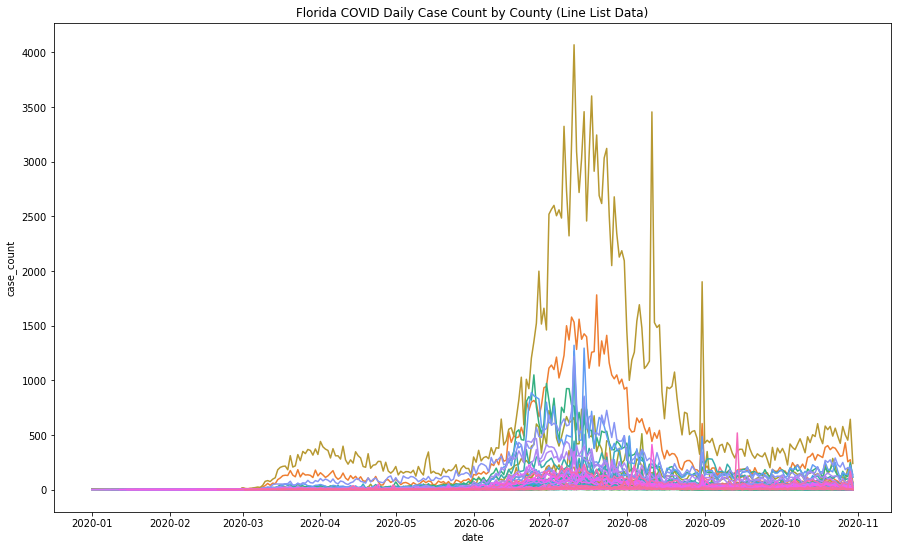

In [494]:
sns.lineplot(x='date', y='case_count', data=case_count,hue= 'county',legend=False)
plt.title('Florida COVID Daily Case Count by County (Line List Data)')

Text(0.5, 1.0, 'Florida COVID Daily Case Count for Polk County (Line List Data)')

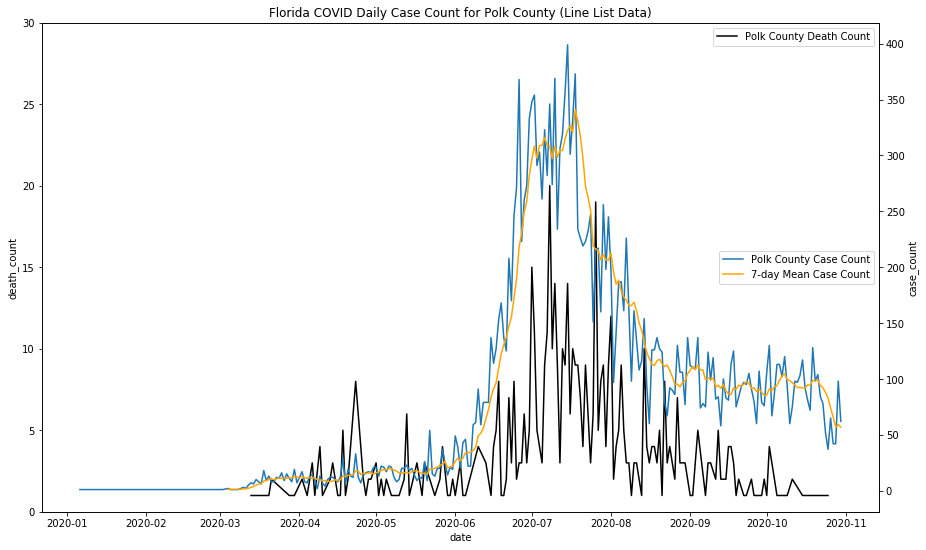

In [564]:
county = 'pol'
win=7
c = covid_daily.loc[covid_daily.county.str.contains(county,flags=re.IGNORECASE)]
max_death = c.death_count.max() +10
ax = sns.lineplot(x='date', y='death_count', data=c ,label=f'{c.county.unique()[0]} County Death Count',color='black')
ax2 = ax.twinx()
ax.set_ylim(0,max_death)
sns.lineplot(x='date', y='case_count', data=c,label=f'{c.county.unique()[0]} County Case Count')
mean_case = c.set_index('date').case_count.rolling(window=win).mean()
mean_case.plot(color='orange',label=f'{win}-day Mean Case Count')
plt.legend(loc='center right')
plt.title(f'Florida COVID Daily Case Count for {c.county.unique()[0]} County (Line List Data)')

Text(0.5, 1.0, 'Florida COVID Total Daily Case Count')

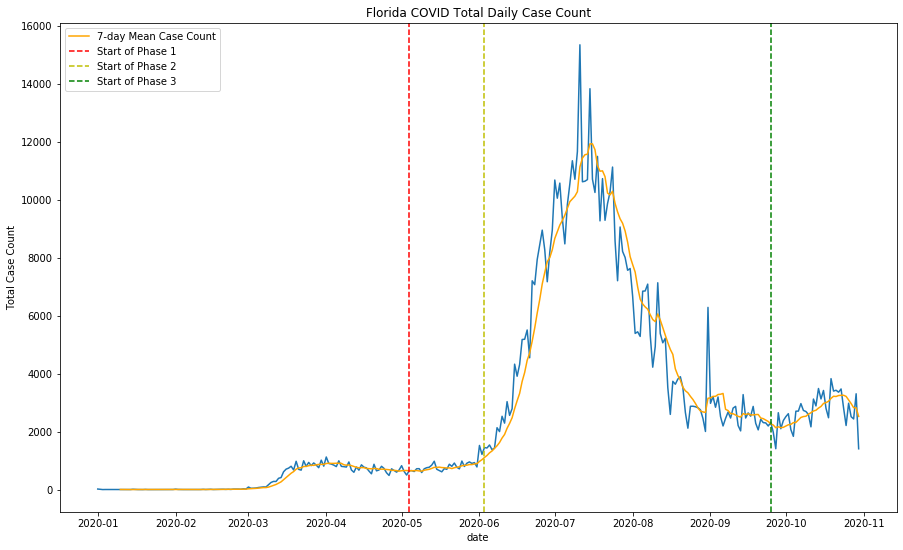

In [565]:
# covid_daily.groupby('date').case_count.sum().plot()
sns.lineplot( x='date', y='case_count', data = fl_daily)
mean_case = fl_daily.set_index('date').case_count.rolling(window=win).mean()
mean_case.plot(color='orange',label=f'{win}-day Mean Case Count')
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend()
plt.ylabel('Total Case Count')
plt.title(f'Florida COVID Total Daily Case Count')

In [522]:
covid_daily.groupby('date').death_count.sum().reset_index()

,date,death_count
0,2020-01-01,0.0
1,2020-01-03,0.0
2,2020-01-04,0.0
3,2020-01-06,0.0
4,2020-01-07,0.0
...,...,...
291,2020-10-26,0.0
292,2020-10-27,1.0
293,2020-10-28,1.0
294,2020-10-29,2.0


Text(0.5, 1.0, 'Florida COVID Total Daily Death Count')

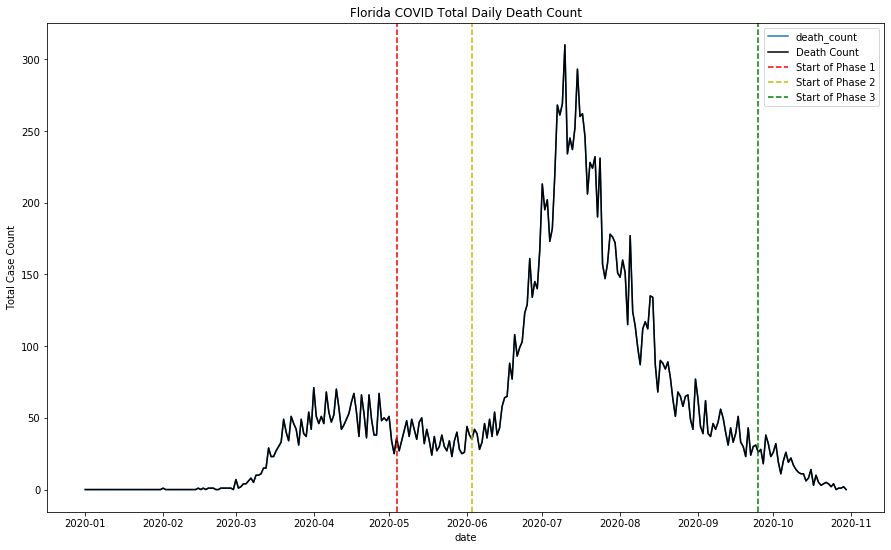

In [524]:
covid_daily.groupby('date').death_count.sum().plot()
sns.lineplot(x='date', y='death_count',color='black',data=covid_daily.groupby('date').death_count.sum().reset_index(), label='Death Count')
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend()
plt.ylabel('Total Case Count')
plt.title(f'Florida COVID Total Daily Death Count')

In [ ]:
line_list.shape

# Trend Analysis

In [ ]:
sns.lineplot(x = 'date', y ='daily_case_count', hue = 'county', data = d1,legend=False)
plt.title('Florida COVID-19 Daily Case Count by Country')

In [ ]:
# Descriptive Analysis

In [ ]:
sns.distplot(df.daily_case_count)
plt.title('Distribution of COVID-19 Case Counts')

In [ ]:
sns.distplot(df.percent_positive)
plt.title('Distribution of COVID-19 Positivity Ratio')

In [ ]:
d1[['daily_case_count','percent_positive']].describe()

In [ ]:
d1.groupby('county')['positive'].sum()

In [ ]:
most_case = d1.daily_case_count.max()
max_sum_case = d1.groupby('date')['daily_case_count'].sum().max()
daily_sum_case = d1.groupby('date')[['daily_neg_count', 'daily_case_count', 'daily_test_count']].sum()
daily_sum_case['pr'] = daily_sum_case.daily_case_count/daily_sum_case.daily_test_count

In [ ]:
d1.columns

Peak in total daily case counts

In [ ]:
daily_sum_case.loc[daily_sum_case.daily_case_count == max_sum_case]

In [ ]:
d1.county.nunique()

In [ ]:
d1.date.max(),d1.date.min()

In [ ]:
rolmean_case.max()
rolmean_case.loc[rolmean_case==rolmean_case.max()]

In [ ]:
d1.columns

In [ ]:
d1.sort_values(by=['county','date'], inplace=True)

In [ ]:
fl.c2_workplace_closing.value_counts()

In [ ]:
dsc = daily_sum_case.reset_index()
dsc.date = pd.to_datetime(dsc.date)
dsc.daily_case_count = dsc.daily_case_count.astype(int)
dsc.info()

In [ ]:
sns.distplot(dsc.daily_case_count)

In [ ]:
dsc

In [ ]:
sns.lineplot(x='date' ,y='pr',c='black', data=dsc, label='Positivity Ratio' )
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2,label='COVID-19 Case Count')
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.title('Florida Daily COVID-19 Case Counts vs. Positivity Ratio')
plt.legend(loc='best')

In [ ]:
sns.lineplot(x='date' ,y='c6_stay_at_home_requirements',c='black', data=fl, label='Stay at Home Requirement Level' )
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.title('Florida Daily COVID-19 Case Counts & Stay at Home Requirement Level')
plt.legend(loc='best')

In [ ]:
sns.lineplot(x='date' ,y='c1_school_closing', data=fl,c='brown', label='School Closure Requirement Level' )
plt.title('Florida Daily COVID-19 Case Counts & School Closure Requirement Level')
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend(loc='best')

In [ ]:
sns.lineplot(x='date' ,y='c2_workplace_closing', data=fl,c='brown', label='School Closure Requirement Level' )
plt.title('Florida Daily COVID-19 Case Counts & School Closure Requirement Level')
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend(loc='best')

In [ ]:

d1['nameoday']= pd.to_datetime(d1.date).dt.day_name()

In [ ]:
d1[['day_of_week','nameoday']].head(50)

In [ ]:
d1.clinical_care_rank.describe()

In [ ]:
# The county with the worst Clinical Care Rating
d1.loc[d1.clinical_care_rank == 67]['county'].unique()

In [ ]:
d1[['phase2','c6_stay_at_home_requirements']].corr(method ='spearman') 

In [ ]:
d1[['phase1','c6_stay_at_home_requirements']].corr(method ='spearman') 

# Testing Area

## TODO:
-[ ] The date format for the daily testing numbers seems to be ISO8601 [Datetime formats](https://www.php.net/manual/en/datetime.formats.date.php)

Description 	Format 	Examples
Eight digit year, month and day 	YY MM DD 	"15810726", "19780417", "18140517"

In [13]:
tests_url = r'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/state_daily_testing/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'

In [15]:
test = requests.get(tests_url).json()

In [22]:
test.keys()

dict_keys(['objectIdFieldName', 'uniqueIdField', 'globalIdFieldName', 'fields', 'features'])

In [23]:
test['features']

[{'attributes': {'Date': 1580187600000,
   'Negative': 1,
   'Positive': 0,
   'Total': 1,
   'PercentPositive': 0,
   'ObjectId': 2492}},
 {'attributes': {'Date': 1580360400000,
   'Negative': 3,
   'Positive': 0,
   'Total': 3,
   'PercentPositive': 0,
   'ObjectId': 2493}},
 {'attributes': {'Date': 1580706000000,
   'Negative': 2,
   'Positive': 0,
   'Total': 2,
   'PercentPositive': 0,
   'ObjectId': 2494}},
 {'attributes': {'Date': 1581051600000,
   'Negative': 1,
   'Positive': 0,
   'Total': 1,
   'PercentPositive': 0,
   'ObjectId': 2495}},
 {'attributes': {'Date': 1581310800000,
   'Negative': 1,
   'Positive': 0,
   'Total': 1,
   'PercentPositive': 0,
   'ObjectId': 2496}},
 {'attributes': {'Date': 1581483600000,
   'Negative': 1,
   'Positive': 0,
   'Total': 1,
   'PercentPositive': 0,
   'ObjectId': 2497}},
 {'attributes': {'Date': 1581656400000,
   'Negative': 3,
   'Positive': 0,
   'Total': 3,
   'PercentPositive': 0,
   'ObjectId': 2498}},
 {'attributes': {'Date': 15

In [61]:
test_num = pd.DataFrame.from_dict(test['features'][0])

In [64]:
test_num = test_num.T

In [65]:
test_num

,Date,Negative,ObjectId,PercentPositive,Positive,Total
attributes,1580187600000,1,2492,0,0,1


In [66]:
for rows in range(1,len(test['features'])):
    row_df = pd.DataFrame.from_dict(test['features'][rows])
    row_df = row_df.T
    test_num = pd.concat([test_num,row_df])

In [90]:
from datetime import datetime, timedelta

In [104]:
pd.to_datetime(test_num.Date, unit='ms')

attributes   2020-01-28 05:00:00
attributes   2020-01-30 05:00:00
attributes   2020-02-03 05:00:00
attributes   2020-02-07 05:00:00
attributes   2020-02-10 05:00:00
                     ...        
attributes   2020-10-26 05:00:00
attributes   2020-10-27 05:00:00
attributes   2020-10-28 05:00:00
attributes   2020-10-29 05:00:00
attributes   2020-10-30 05:00:00
Name: Date, Length: 253, dtype: datetime64[ns]

In [96]:
start = datetime(1970, 1, 1)

In [97]:
test_num['date1'] = test_num.Date.apply(lambda x: start + timedelta(seconds=x))

OverflowError: date value out of range

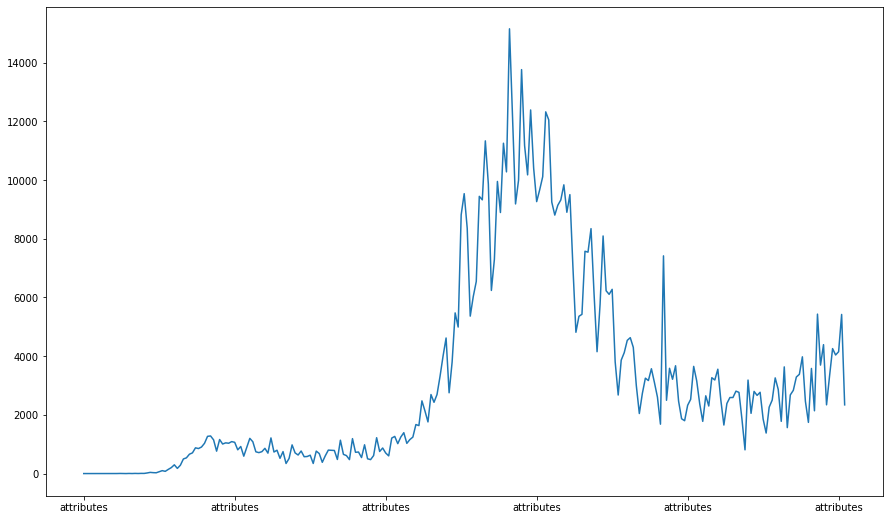

In [88]:
test_num.Positive.plot()